In [11]:
from functools import partial
from pathlib import Path

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, solve_ode, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    MiniBatching,
    RandomSampleBatching,
)
from dynamics_discovery.models import NeuralODE, ODEModel
from dynamics_discovery.neighborhood import (
    NeighborhoodMSELoss,
    NeighborhoodSegmentLoader,
    NeuralNeighborhoodFlow,
)
from jaxtyping import Array, Float, PyTree
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

Consider a state vector $\boldsymbol{x}\in \mathbb{R}^d$ whose dynamics is governed by the ODE
\begin{equation}
\frac{d\boldsymbol{x}}{dt} = f(\boldsymbol{x}).
\end{equation}

The evolution of small deviations $\boldsymbol{\delta x}(t) \in \mathbb{R}^d$ around $\boldsymbol{x}(t)$ is described by the variational equation:
\begin{equation}
\frac{d\boldsymbol{\delta x}}{dt} = \nabla_{\boldsymbol{x}}f(\boldsymbol{x}(t))\boldsymbol{\delta x} = J(\boldsymbol{x})\boldsymbol{\delta x}.
\end{equation}

As this equation is linear with respect to $\boldsymbol{\delta x}$, we can instead consider the following matrix differential equation
\begin{equation}
\frac{d\boldsymbol{M}}{dt} = J(\boldsymbol{x})\boldsymbol{M}, \; \boldsymbol{M}(t=0) = \boldsymbol{I}
\end{equation}
where $\boldsymbol{M}(t;\boldsymbol{x})\in \mathbb{R}^{d\times d}$ is the tangent evolution matrix (or operator), and $\boldsymbol{I}$ is the $d\times d$ identity matrix.

In the vincinity of $\boldsymbol{x}(t)$, the tangent evolution matrix linearly maps the perturbations forward in time:
\begin{equation}
\boldsymbol{\delta x}(t+\tau) = \boldsymbol{M}(\tau;\boldsymbol{x}(t))\boldsymbol{\delta x}(t).
\end{equation}

Thus, when the number of deviations to forecast $m$ is larger than $d$, it is more economical to compute the tangent evolution matrix instead of directly solving the variational equation for the individual perturbations.

In [3]:
noise = 0.0
downsample = 40
dataset, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(5000, 250, 3)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u.reshape(-1, 3).T, s=0.5)

In [3]:
num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=2048)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)


In [5]:
dataset.u.shape

(5000, 1000, 3)

In [10]:
idx_u = 1000

t = batch[0][idx_u]
u = batch[1][idx_u]
u_nn = batch[2][idx_u]
du_nn = u_nn - jnp.expand_dims(u, -2)


tangent_ode = NeuralNeighborhoodFlow(TransformedODE(Lorenz63(), transform))

u_pred, du_nn_pred = solve_ode(
    tangent_ode,
    t,
    (u[0], du_nn[0]),
    rtol=1e-4,
    atol=1e-6,
    max_steps=None,
)
# du_nn_pred = jnp.permute_dims(du_nn_pred, (0, 2, 1))
u_nn_pred1 = jnp.expand_dims(u, -2) + du_nn_pred
u_nn_pred2 = jnp.expand_dims(u_pred, -2) + du_nn_pred

Text(0.5, 0.98, 'Downsample = 40, Noise = 0.0, # neighbors = 30')

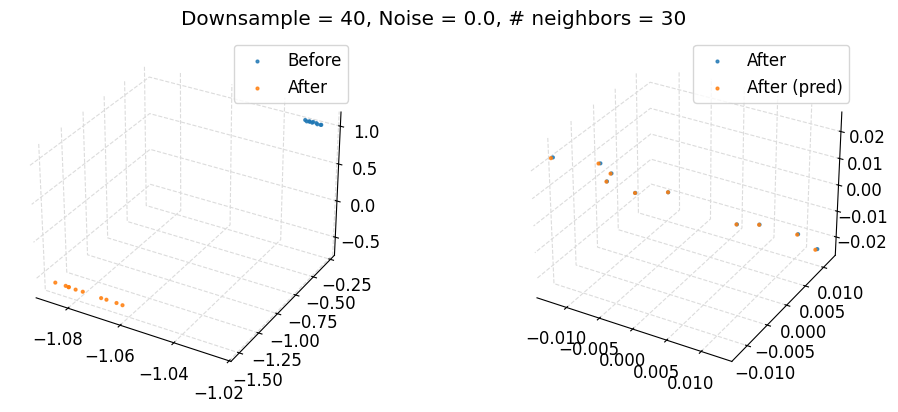

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
axes[0].scatter(*u_nn[0].T, label="Before", **scatter_kwargs)
axes[0].scatter(*u_nn[1].T, label="After", **scatter_kwargs)

# axes[1].scatter(*u_nn0[1:].T, label="Before", s=2.0, alpha=0.2)
axes[1].scatter(*du_nn[1].T, label="After", **scatter_kwargs)
axes[1].scatter(*du_nn_pred[1].T, label="After (pred)", **scatter_kwargs)
for ax in axes:
    ax.legend()

fig.suptitle(f"Downsample = {downsample}, Noise = {noise}, # neighbors = {30}")
## TODO: Compare how different metrics degrade as a function of noise amplitude
# ex. MSE between neighborhood positions, a more distribution-based metric, normal vectors, etc.


Text(0.5, 0.98, 'Downsample = 10, Noise = 0.01, # neighbors = 30')

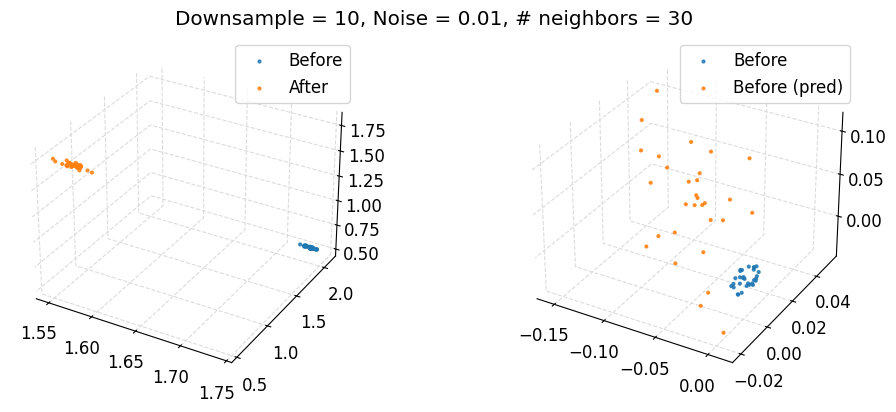

In [18]:
u_pred_inv, du_nn_pred_inv = solve_ode(
    tangent_ode,
    t[::-1],
    (u[1], du_nn[1]),
    rtol=1e-4,
    atol=1e-6,
    max_steps=None,
)
# du_nn_pred = jnp.permute_dims(du_nn_pred, (0, 2, 1))
# u_nn_pred1 = jnp.expand_dims(u, -2) + du_nn_pred
# u_nn_pred2 = jnp.expand_dims(u_pred, -2) + du_nn_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
axes[0].scatter(*u_nn[0].T, label="Before", **scatter_kwargs)
axes[0].scatter(*u_nn[1].T, label="After", **scatter_kwargs)

# axes[1].scatter(*u_nn0[1:].T, label="Before", s=2.0, alpha=0.2)
axes[1].scatter(*du_nn[0].T, label="Before", **scatter_kwargs)
axes[1].scatter(
    *du_nn_pred_inv[1].T,
    label="Before (pred)",
    **scatter_kwargs,
)
for ax in axes:
    ax.legend()

fig.suptitle(f"Downsample = {downsample}, Noise = {noise}, # neighbors = {30}")
## TODO: Compare how different metrics degrade as a function of noise amplitude
# ex. MSE between neighborhood positions, a more distribution-based metric, normal vectors, etc.


In [12]:
from ott.utils import batched_vmap


loss_fn = NeighborhoodMSELoss()


@jax.jit
@partial(batched_vmap, batch_size=5, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = NeuralNeighborhoodFlow(ODEModel(TransformedODE(ode, transform)))
    return loss_fn(model, batch, None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Downsample = 40, Noise = 0.0, # neighbors = 10')

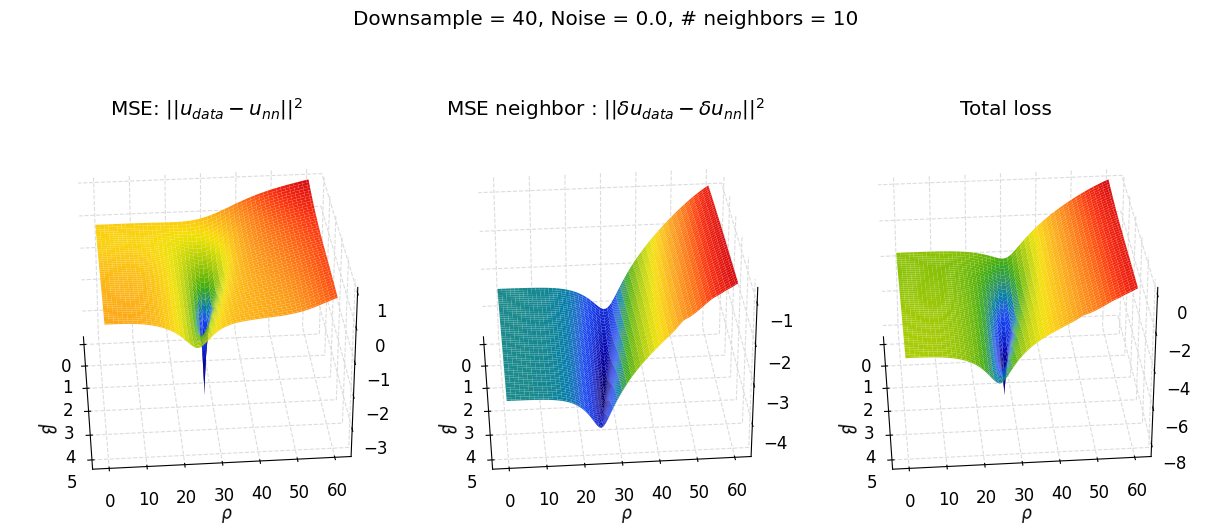

In [14]:
import colorcet as cc
import numpy as np


fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["mse_neighbors"]),
    np.log10(loss_array["mse"]) + np.log10(loss_array["mse_neighbors"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"MSE neighbor : $||\delta u_{data}-\delta u_{nn}||^2$")
axes[2].set_title(r"Total loss")

fig.suptitle(
    f"Downsample = {downsample}, Noise = {noise}, # neighbors = {num_neighbors}", fontsize="large"
)

In [25]:
from typing import Any

from dynamics_discovery.custom_types import FloatScalar
from dynamics_discovery.loss_functions import AbstractDynamicsLoss
from jaxtyping import PyTree


class NeighborhoodMSELoss2(AbstractDynamicsLoss):
    weight: float = 1.0
    batch_size: int | None = None

    def __call__(
        self,
        model: NeuralNeighborhoodFlow,
        batch: PyTree[Float[Array, "batch ..."]],
        args: Any = None,
        **kwargs: Any,
    ) -> FloatScalar:
        t_data: Float[Array, "batch time_batch"]
        u_data: Float[Array, "batch time_batch dim"]
        u_nn_data: Float[Array, "batch time_batch neighbors dim"]
        # weights: Float[Array, "batch neighbors"]
        # t_data, u_data, du_data, weights = batch
        t_data, u_data, u_nn_data = batch

        batch_size = u_data.shape[0] if self.batch_size is None else self.batch_size
        len_neighbors = u_nn_data.shape[1]

        @partial(batched_vmap, in_axes=(0, 0, 0), batch_size=batch_size)
        def _solve(
            t: Float[Array, " time_batch_neighbors"],
            u0: Float[Array, " dim"],
            du0: Float[Array, " neighbors dim"],
        ):
            return model.solve(
                t,
                (u0, du0),
                **kwargs,
            )

        @partial(batched_vmap, in_axes=(0, 0), batch_size=batch_size)
        def _solve_ode(
            t: Float[Array, " {time_batch-time_batch_neighbors}"],
            u0: Float[Array, " dim"],
        ):
            return model.ode.solve(
                t,
                u0,
                **kwargs,
            )

        du_nn_data = u_nn_data - jnp.expand_dims(u_data, 2)
        u_pred, du_pred = _solve(
            t_data[:, :len_neighbors], u_data[:, 0], du_nn_data[:, 0]
        )

        u_pred_inv, du_pred_inv = _solve(
            t_data[:, 0:len_neighbors][:, ::-1],
            u_data[:, len_neighbors - 1],
            du_nn_data[:, -1],
        )
        # u_nn_pred = jnp.expand_dims(u_pred, 2) + du_pred

        # mse_neighbors = jnp.mean(
        #     jnp.sum(
        #         jnp.mean((u_nn_pred - u_nn_data) ** 2, axis=(1, 3)) * weights, axis=-1
        #     )
        #     # / jnp.clip(
        #     #     jnp.sum(weights, axis=-1), min=1
        #     # )  # Trick do avoid divide by zero
        # )
        # mse_neighbors = jnp.mean((u_nn_pred - u_nn_data) ** 2)
        # mse_neighbors = jnp.mean((du_pred - du_nn_data) ** 2) + jnp.mean(
        #     (du_pred_inv[:, ::-1] - du_nn_data) ** 2
        # )
        # mse_neighbors = jnp.mean((du_pred_inv[:, ::-1] - du_nn_data) ** 2)
        mse_neighbors = jnp.mean((u_pred_inv[:, ::-1] - u_data) ** 2)
        # u_pred_rest = _solve_ode(t_data[:, len_neighbors - 1 :], u_pred[:, -1])
        # u_pred_total = jnp.concatenate((u_pred, u_pred_rest[:, 1:]), axis=1)
        # mse_total = jnp.mean((u_pred_total - u_data) ** 2)
        mse_total = jnp.mean((u_pred - u_data) ** 2)
        return mse_total + self.weight * mse_neighbors, {
            "mse": mse_total,
            "mse_neighbors": mse_neighbors,
        }

        # return (mse_total + n_neighbors * mse_neighbors) / (n_neighbors + 1), {
        #     "mse": mse_total,
        #     "mse_neighbors": mse_neighbors,
        # }


Text(0.5, 0.98, 'Downsample = 10, Noise = 0.01, # neighbors = 30')

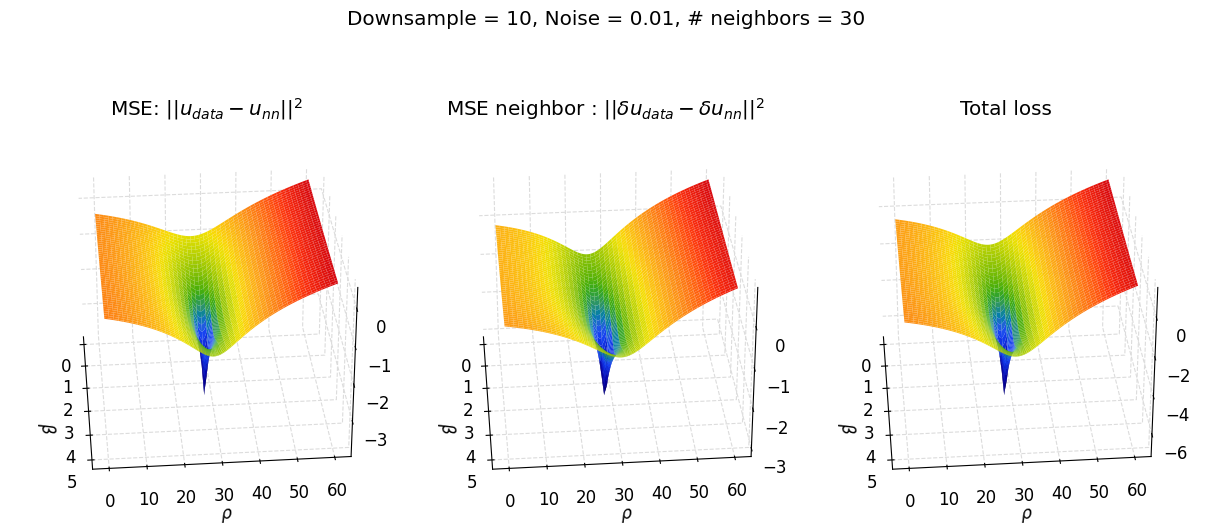

In [26]:
from ott.utils import batched_vmap


loss_fn = NeighborhoodMSELoss2()


@jax.jit
@partial(batched_vmap, batch_size=5, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = NeuralNeighborhoodFlow(ODEModel(TransformedODE(ode, transform)))
    return loss_fn(model, batch, None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)

import colorcet as cc
import numpy as np


fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["mse_neighbors"]),
    np.log10(loss_array["mse"]) + np.log10(loss_array["mse_neighbors"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"MSE neighbor : $||\delta u_{data}-\delta u_{nn}||^2$")
axes[2].set_title(r"Total loss")

fig.suptitle(
    f"Downsample = {downsample}, Noise = {noise}, # neighbors = 30", fontsize="large"
)

In [ ]:
from dynamics_discovery.loss_functions import JacobianMatchingMSE


loss_fn2 = JacobianMatchingMSE(TransformedODE(Lorenz63(), transform))


@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params2(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = ODEModel(TransformedODE(ode, transform))
    return loss_fn2(model, batch[0:2], None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)

beta_array = jnp.linspace(0, 5.0, 50)
rho_array = jnp.linspace(0.0, 60.0, 50)


In [223]:
loss_array2 = loss_from_params2(10.0, beta_grid, rho_grid)

Text(0.5, 0.98, 'Downsample = 10, Noise = 0.0005')

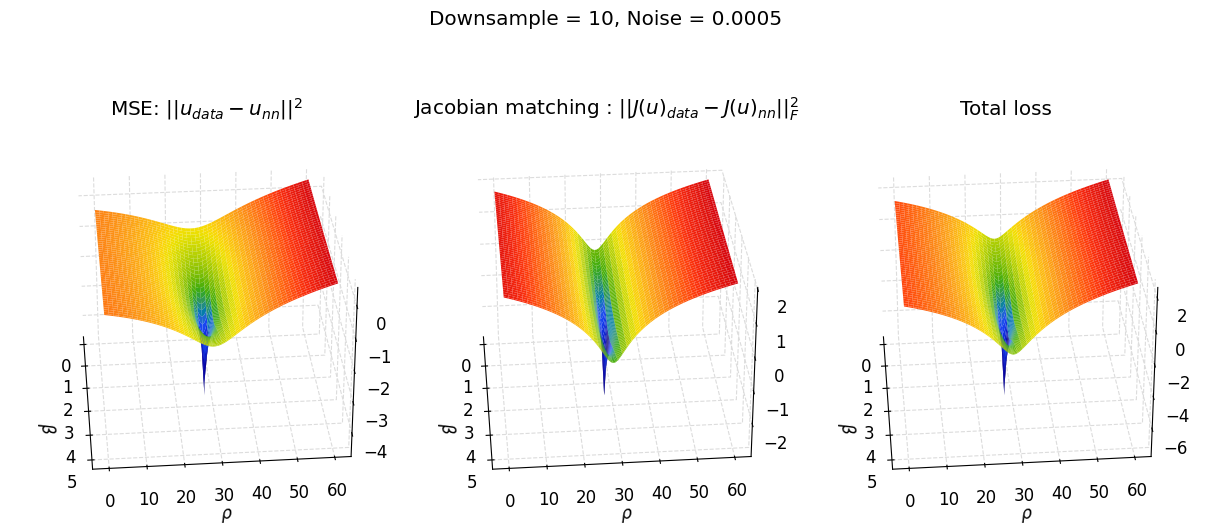

In [224]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array2["mse"]),
    np.log10(loss_array2["jac_loss"]),
    np.log10(loss_array2["mse"]) + np.log10(loss_array2["jac_loss"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(r"Jacobian matching : $||J(u)_{data}-J(u)_{nn}||_F^2$")
axes[2].set_title(r"Total loss")
fig.suptitle(f"Downsample = {downsample}, Noise = {noise}", fontsize="large")


In [5]:
loader_state[0][0].shape

(1245000,)

## Prototype implementing the ConFIG method

In [ ]:
from dynamics_discovery.training.multiterm import filter_value_and_grad_ConFIG


loss_fn_multi = NeighborhoodMSELoss(multiterm=True)
model = NeuralNeighborhoodFlow(NeuralODE(3, 32, 3))

num_neighbors = 10
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=2048)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [66]:
loss, vjp_fun, aux = eqx.filter_vjp(lambda m: loss_fn_multi(m, batch), model, has_aux=True)

[(32, 3), (32,), (32, 32), (32,), (32, 32), (32,), (3, 32), (3,)]

In [ ]:


config_grad_fn = filter_value_and_grad_ConFIG(loss_fn_multi, has_aux=True)

In [96]:
(loss, aux), grad_config = config_grad_fn(model, batch)
print(loss)
print(aux)
print(grad_config)

1.0615665930098708
{'mse': Array(1.06110904, dtype=float64), 'mse_neighbors': Array(0.00045755, dtype=float64)}
NeuralNeighborhoodFlow(
  ode=NeuralODE(
    net=MLP(
      layers=(
        Linear(
          weight=f64[32,3],
          bias=f64[32],
          in_features=3,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[32,32],
          bias=f64[32],
          in_features=32,
          out_features=32,
          use_bias=True
        ),
        Linear(
          weight=f64[3,32],
          bias=f64[3],
          in_features=32,
          out_features=3,
          use_bias=True
        )
      ),
      activation=None,
      final_activation=None,
      use_bias=True,
      use_final_bias=True,
      in_size=3,
      out_size=3,
      width_size=32,
      depth=3
    ),
    dim=3,


In [3]:
import numpy as np
from tqdm import tqdm


loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    30,
    MiniBatching(batch_size=10000, permute_initial=False, drop_last=False),
)
loader_state = loader.init()

u_neighbors = []
for i in tqdm(range(loader.num_batches)):
    batch, loader_state = loader.load_batch(loader_state)
    u_neighbors.append(np.asarray(batch[2]))

100%|██████████| 125/125 [00:32<00:00,  3.84it/s]


In [6]:
u_neighbors[-2].shape

(10000, 2, 30, 3)

In [4]:
loader = NeighborhoodSegmentLoader(dataset, 2, 30, MiniBatching(batch_size=10000))
loader_state = loader.init()
loader_state

((Array([2052612, 4922476, 3295904, ...,  823700, 3925540, 1025065], dtype=int64),
  0,
  Array((), dtype=key<fry>) overlaying:
  [1797259609 2579123966]),)

In [5]:
jax.random.permutation(jax.random.key(0), 5)

Array([0, 1, 4, 3, 2], dtype=int64)

In [3]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-7, atol=1e-9
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension

In [4]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, t_train[n_steps - 1] - t_train[0]
    )
)(u_train[: -n_steps + 1])

In [5]:
import scipy.signal as scsignal


u_smooth = scsignal.savgol_filter(u_train, window_length=7, polyorder=3, axis=0)
u_smooth.shape

(10000, 3)

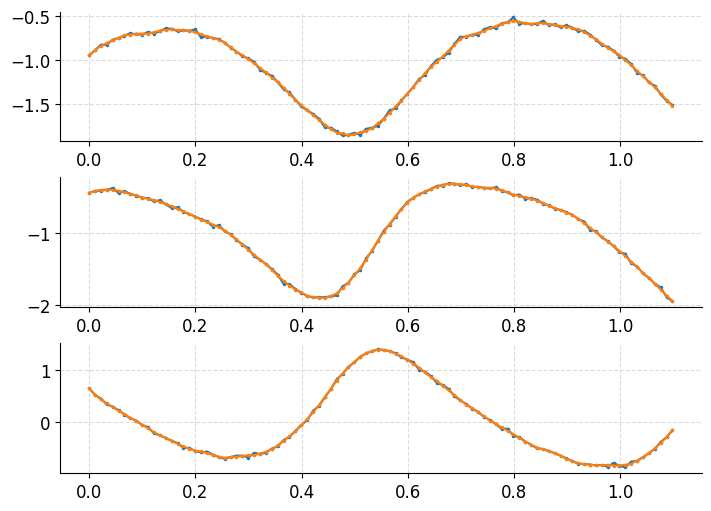

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5))
for i, ax in enumerate(axes):
    ax.plot(t_train[:100], u_train[:100, i], ".-")
    ax.plot(t_train[:100], u_smooth[:100, i], ".-")

In [7]:
_, _, du, _ = create_neighborhood_dataset(
    t_train,
    u_smooth,
    num_neighbors=30,
    train_length=n_steps,
    train_length_neighbors=n_steps,
    min_radius=0.2,
    max_radius=0.4,
)

In [8]:
du.shape

(9999, 2, 30, 3)

In [9]:
du0, du1 = du[:, 0], du[:, -1]

M_data = jnp.permute_dims((jnp.linalg.pinv(du0) @ du1).T, (2, 0, 1))

In [10]:
du0_test = du0[0]
du0_test.shape

(30, 3)

In [11]:
import itertools


def batched_outer(
    x: Float[Array, "*dims_x"], y: Float[Array, " dim_y"]
) -> Float[Array, "*dims_x dim_y"]:
    """Compute a (batched) outer product between a n(>1)D tensor x and a 1D tensor y.

    For x of shape (i_0, ..., i_{n-1}) and y of shape (j,), the output tensor has the
    shape (i_0, ..., i_{n-1}, j)."""
    return jnp.expand_dims(x, axis=-1) * y


def monomial_basis_unique(x, order: int):
    arr = jnp.asarray(list(itertools.combinations_with_replacement(x, order)))
    return jnp.prod(arr, axis=-1)


def make_monomial_features(x, max_order: int = 2):
    """Given a vector x=[x1,x2,x3], create a 1D vector containing all the monomial
    basis terms upto order n.

    For n=2, this corresponds to [x1, x2, x3, x1^2, x1x2, x1x3, x2x1, x2^2, x2x3, x3x1,
    x3x2, x3^2]"""
    terms = [monomial_basis_unique(x, i) for i in range(1, max_order + 1)]
    return jnp.concatenate(terms)


In [12]:
du0_second_order = jax.vmap(jax.vmap(lambda x: make_monomial_features(x, 3)))(du0)
du0_second_order.shape

(9999, 30, 19)

In [13]:
du0_second_order[0, 0]

Array([ 1.15314194e-01,  1.57277650e-01, -4.86175360e-02,  1.32973634e-02,
        1.81363455e-02, -5.60629199e-03,  2.47362592e-02, -7.64645181e-03,
        2.36366481e-03,  1.53337475e-03,  2.09137807e-03, -6.46485044e-04,
        2.85244180e-03, -8.81744430e-04,  2.72564103e-04,  3.89046072e-03,
       -1.20261597e-03,  3.71751646e-04, -1.14915559e-04], dtype=float64)

In [14]:
M_data2 = jnp.permute_dims((jnp.linalg.pinv(du0_second_order) @ du1).T, (2, 0, 1))[
    ..., :3
]
M_data2.shape

(9999, 3, 3)

In [15]:
err = jnp.linalg.norm(M_pred - M_data, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)
err2 = jnp.linalg.norm(M_pred - M_data2, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)

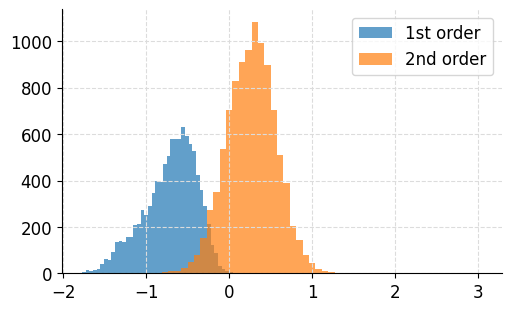

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(err), bins=50, alpha=0.7, label="1st order")
ax.hist(jnp.log10(err2), bins=50, alpha=0.7, label="2nd order")
ax.legend()

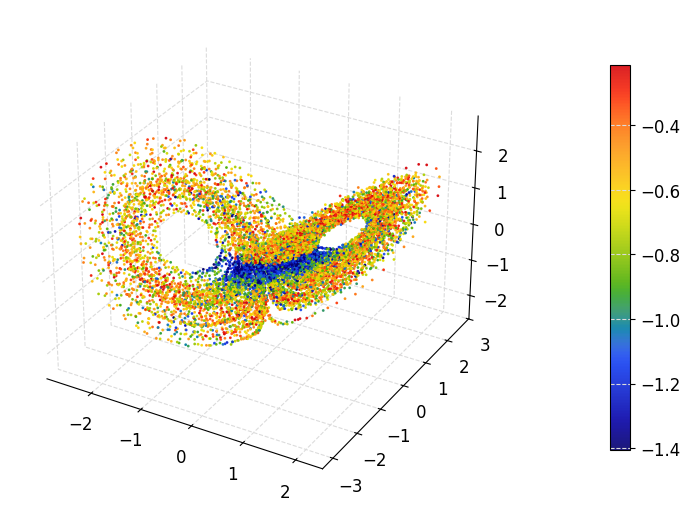

In [17]:
import colorcet as cc
import numpy as np


scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(jnp.log10(err), 2.5),
    "vmax": np.percentile(jnp.log10(err), 97.5),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_train[: -n_steps + 1].T,), (jnp.log10(err),), **scatter_kwargs
)

In [ ]:
ode = NeuralODE(3, 32, 3, key=0, solver=dfx.Tsit5(), rtol=1e-4, atol=1e-6)
model = NeuralNeighborhoodFlow(ode, use_seminorm=False, second_order=False)


SyntaxError: positional argument follows keyword argument (2378072622.py, line 1)